In [60]:
# https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710
import cv2
import imutils
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import os.path
import glob
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import pickle
import tensorflow
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense

In [61]:
def show_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Croping the image

The goal of this algorithm is to crop the images of the captcha in such a way we can mark it in an easier way when using the captcha of the globo.com

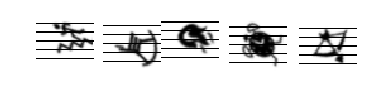

In [94]:
image = cv2.imread("captchas20/cadeira.png", 0)
imageColor = cv2.imread("captchas20/cadeira.png")
plt.imshow(imageColor)
plt.axis('off')
plt.show()

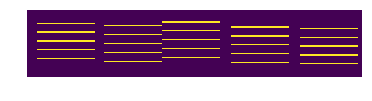

In [100]:
## remove the horizontal lines
gray = cv2.bitwise_not(image)
bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                                cv2.THRESH_BINARY, 15, -2)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove horizontal
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
# detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
# cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# print(cnts)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     cv2.drawContours(imageColor, [c], -1, (255,0,0), 2)

# extract the image containing every single horizontal line
h_image = gray.copy()
h_image_eroded = cv2.erode(h_image, horizontal_kernel)
h_image_dilated = cv2.dilate(h_image_eroded, horizontal_kernel)

show_image(h_image_dilated)

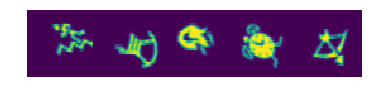

In [106]:
v_image = gray.copy()
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,2))
v_image_eroded = cv2.erode(v_image, vertical_kernel)
v_image_dilated = cv2.dilate(v_image_eroded, vertical_kernel)
show_image(v_image_dilated)

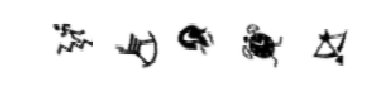

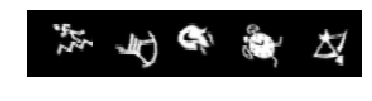

In [147]:
img = cv2.bitwise_not(v_image_dilated)
imgOriginal = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
reversedOriginal = cv2.cvtColor(v_image_dilated, cv2.COLOR_GRAY2BGR)
show_image(imgOriginal)
show_image(reversedOriginal)

# Separate parts of the image
Get the image and split it in the five objects

In [141]:
def findLetters(imgErode):
    contours = cv2.findContours(imgErode, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    contours = contours[0]
    imageRegions = []
    areaArr = []

    for contour in contours:
        area = cv2.contourArea(contour)
        areaArr.append(area)

    
    # encontrando mediana para descartar áreas fora do padrão
    median = 0
    areaArr.sort()
    print(len(areaArr))
    if len(areaArr)%2 != 0:
        mid = int(len(areaArr)/2)
        median = areaArr[mid]
    else:
        mid = int(len(areaArr)/2)
        median = (areaArr[mid] + areaArr[mid - 1])/2
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 3*median or area < median/3:
            continue;

        x, y, w, h = cv2.boundingRect(contour)
        imgRGB = cv2.cvtColor(imgErode,cv2.COLOR_GRAY2RGB)
    
        # se duas letras estiverem juntas
        if w/h > 1.25:
            half_width = int(w/2)
            imageRegions.append((x, y, half_width, h))
            imageRegions.append((x + half_width, y, half_width, h))
        else:
            imageRegions.append((x, y, w, h))
    
    imageRegions = sorted(imageRegions, key=lambda x: x[0])
    
    return imageRegions


In [142]:
def printRegions(imageRegions):
    for point in imageRegions:    
        imgRGB = cv2.cvtColor(imgErode, cv2.COLOR_GRAY2RGB)
        imgRect = cv2.rectangle(imgRGB, (point[0], point[1]), (point[0]+point[2], point[1]+point[3]), (255,0,0), 1)

        plt.imshow(imgRect)
        plt.axis('off')
        plt.show()

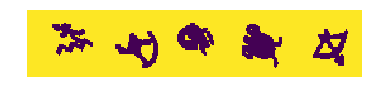

I found 14 black shapes


In [143]:
imgMask = cv2.inRange(img, 220, 255)
show_image(imgMask)
contours = cv2.findContours(imgMask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(contours)
print("I found {} black shapes".format(len(cnts)))
# imageRegions = findLetters(imgMask)
# printRegions(imageRegions)

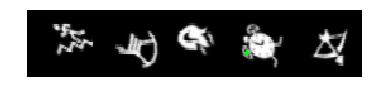

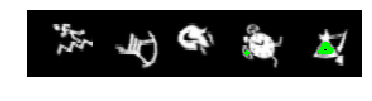

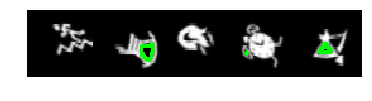

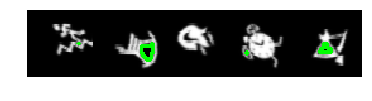

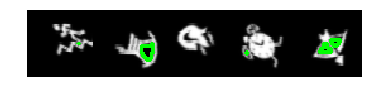

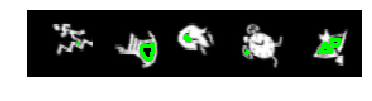

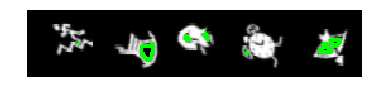

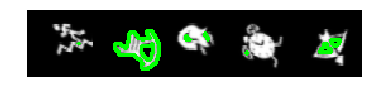

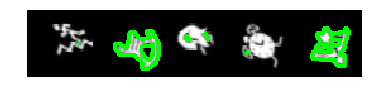

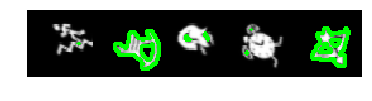

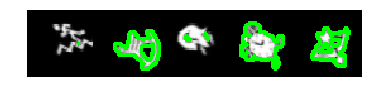

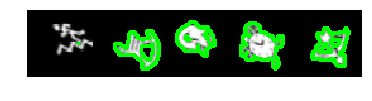

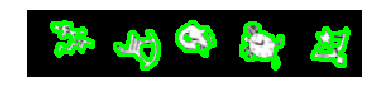

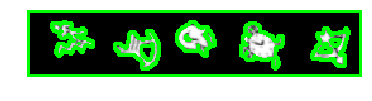

In [148]:
cntImg = reversedOriginal.copy()
# loop over the contours
for c in cnts:
    # draw the contour and show it
    cv2.drawContours(cntImg, [c], -1, (0, 255, 0), 2)
    show_image(cntImg)
#     cv2.imshow("Image", cntImg)
#     cv2.waitKey(0)

# show_image(cntImg)

In [250]:
def checkWhiteCol(gray, col):
    for p in range(gray.shape[0]):
        if gray[p][col] < 200:
            return False
    return True

def checkBlackCol(gray, col):
    for p in range(gray.shape[0]):
        if gray[p][col] > 50:
            return False
    return True

def checkWhiteRow(gray, row):
    for p in range(gray.shape[1]):
        if gray[row][p] < 200:
            return False
    return True

def checkBlackRow(gray, row):
    for p in range(gray.shape[1]):
        if gray[row][p] > 50:
            return False
    return True

In [259]:
def findImages(image):
    # flag for true - whitezone; false - blackzone
    images = []
    flag = True
    startZone = 0
    endZone = 0
    # iterate in every column
#     print(image.shape[1])
    for col in range(image.shape[1]):
        if flag and not checkBlackCol(image, col):
#             print("here")
            flag = False
            startZone = col
        elif not flag and checkBlackCol(image, col):
                endZone = col
                tmp = image[:, startZone:endZone]
                rowFlag = True
                stRow = 0
                endRow = 0
                for row in range(tmp.shape[0]):
#                     print(checkBlackRow(tmp, row))
#                     if checkBlackRow(tmp, row):
#                         print(tmp[row][:])
#                     print(tmp[row][:])
                    if rowFlag and not checkBlackRow(tmp, row):
                        rowFlag = False
                        stRow = row
                    elif not rowFlag and checkBlackRow(tmp, row):
                        endRow = row
                        tmp = tmp[stRow:endRow,:]
#                         print(stRow, endRow)
                        break
                images += [tmp]
#                 images += [(startZone, endZone)]
                flag = True
    return images

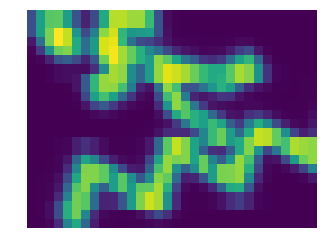

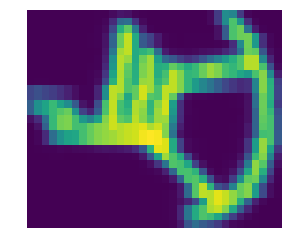

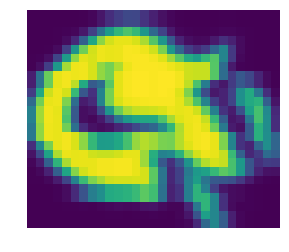

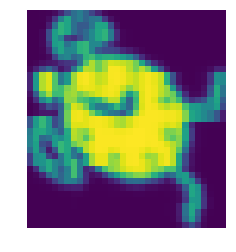

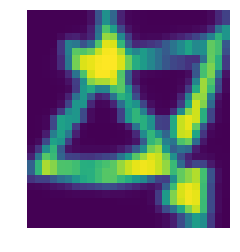

In [260]:
images = findImages(v_image_dilated)
# print(len(images))
# print(images)
for image in images:
#     begin, end = image
#     show_image(v_image_dilated[:, begin:end])
    show_image(image)
    

In [263]:
def remove_lines(image):
    gray = cv2.bitwise_not(image)
    # Remove horizontal
    v_image = gray.copy()
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,2))
    v_image_eroded = cv2.erode(v_image, vertical_kernel)
    v_image_dilated = cv2.dilate(v_image_eroded, vertical_kernel)
    return v_image_dilated

def checkBlackCol(gray, col):
    for p in range(gray.shape[0]):
        if gray[p][col] > 50:
            return False
    return True

def checkBlackRow(gray, row):
    for p in range(gray.shape[1]):
        if gray[row][p] > 50:
            return False
    return True

def extract_basic_image(path):
    image = cv2.imread(path, 0)
    elements = remove_lines(image)
    return elements

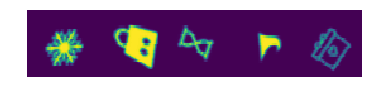

In [266]:
basic_image = extract_basic_image("captchas20/caixa.png")
show_image(basic_image)

In [267]:
def findImages(image):
    images = []
    # flag for true - whitezone; false - blackzone
    flag = True
    startZone = 0
    endZone = 0
    for col in range(image.shape[1]):
        if flag and not checkBlackCol(image, col):
            flag = False
            startZone = col
        elif not flag and checkBlackCol(image, col):
                endZone = col
                tmp = image[:, startZone:endZone]
                rowFlag = True
                stRow = 0
                endRow = 0
                for row in range(tmp.shape[0]):
                    if rowFlag and not checkBlackRow(tmp, row):
                        rowFlag = False
                        stRow = row
                    elif not rowFlag and checkBlackRow(tmp, row):
                        endRow = row
                        tmp = tmp[stRow:endRow,:]
                        break
                images += [tmp]
                flag = True
    return images

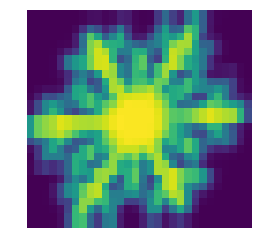

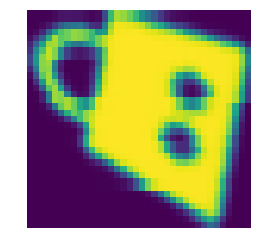

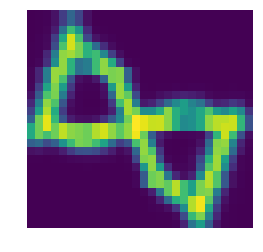

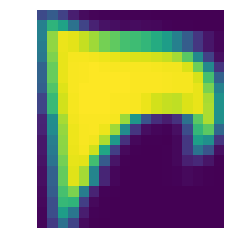

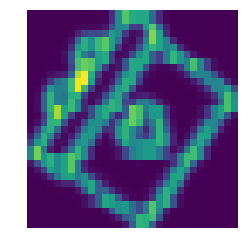

In [268]:
all_images = findImages(basic_image)
for image in all_images:
    show_image(image)

# Find in the original image the elements

In [291]:
test_image = extract_basic_image("captchas20/caixa.png")

In [292]:
def findInCaptcha(img, template):
    w, h = template.shape[::-1]

    res = cv2.matchTemplate(img,template,cv2.TM_SQDIFF_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = min_loc

    bottom_right = (top_left[0] + w, top_left[1] + h)
    found = cv2.rectangle(img,top_left, bottom_right, 0, 2)
    
    found = img[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
    show_image(found)

#     print("salvando")
#     cv2.imwrite('matchCaptcha20/' + filename, img)

    return [top_left[0] + w/2, top_left[1] + h/2]

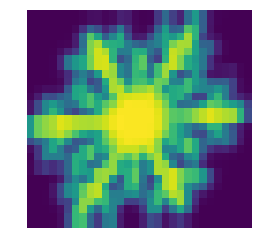

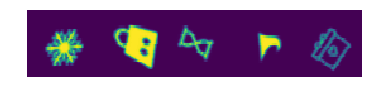

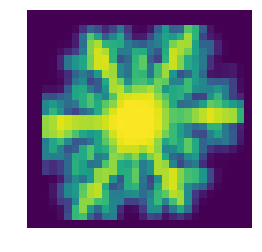

[30.0, 29.5]

In [293]:
show_image(all_images[0])
show_image(test_image)
findInCaptcha(test_image, all_images[0])